The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
calculated induced drag: 1146.6069256518274, xflr induced drag: 1083.2264999578163
calculated viscous drag: 1792.8501570512105, xflr viscous drag: 1733.9916405189977
required angle of attack: 2.4


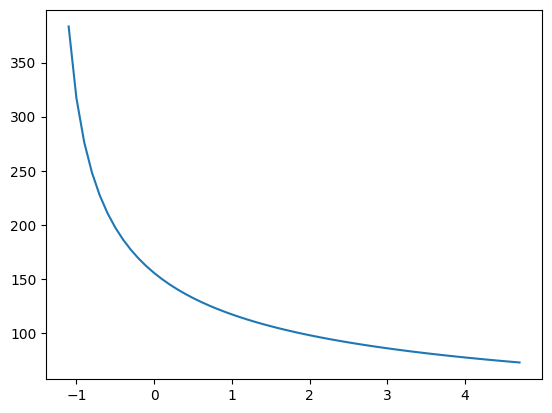

In [6]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

#function for finding closest index to value within threshold
def find_closest_index(array, n, t):
    array = np.asarray(array)
    
    differences = np.abs(array - n)
    
    within_threshold_indices = np.where(differences <= t)[0]
    
    if len(within_threshold_indices) == 0:
        return None

    closest_index = within_threshold_indices[np.argmin(differences[within_threshold_indices])]
    
    return closest_index

#given in problem
m = 11000 #in kg
altitude = 3048 #in m
speed = 93 #in m/s
span = 14.5 * 2 #in m
temperature = 268.338 #in K
pressure = 69681.7 #in Pa
air_density = 0.904637 #in kg/m^3
speed_sound = 328.387 #in m/s
dynamic_viscosity = 0.0000171150 # in N s/m^2
inviscid_span_efficiency = 0.98
k_lift_viscous = 0.38
mean_radius_earth = 6378.137e3 #in m
g_sl = 9.80665 #in m/s^2
S_ref_xflr = 80

#intermediate quantities
mean_thickness_to_chord_ratio = (0.06 + 0.15) / 2
mean_chord = (4.4 + 1.1) / 2 #in m
mach_number = speed / speed_sound
q = (1 / 2) * air_density * speed**2
reynold_number = air_density * speed * mean_chord / dynamic_viscosity
S_wing = 2 * (14.5*1.1 + ((4.4 - 1.1) * 14.5 / 2))
S_wet_wing = 2 * (1 + 0.2 * mean_thickness_to_chord_ratio) * S_wing
g = g_sl * (mean_radius_earth / (mean_radius_earth + altitude))**2
AR = span**2 / S_wing

#parasitic drag
cf_inc = (0.074 / reynold_number**0.2) * 0.8
cf = cf_inc * (1 + 0.144 * mach_number**2)**-0.65
Z = (2 - mach_number**2) * np.cos(np.deg2rad(0)) / np.sqrt(1 - mach_number**2 * np.cos(np.deg2rad(0))**2)
k = 1 + Z * mean_thickness_to_chord_ratio + 100 * (mean_thickness_to_chord_ratio)**4
drag_parasitic = cf * S_wet_wing * k * q

cdp = k * cf * S_wet_wing / S_wing
cl = m * g / (q * S_wing)

#viscous lift dependent drag
cd = k_lift_viscous * cdp * cl**2
drag_viscous_dependent = cd * S_wing * q

#induced drag
cdi = cl**2 / (np.pi * AR * inviscid_span_efficiency)
drag_induced = cdi * S_wing * q

#total drag
drag_total = drag_parasitic + drag_viscous_dependent + drag_induced

#graphs from xflr
speed_graph = np.genfromtxt('speed_alpha.csv',delimiter=',')
speed_graph_alpha = speed_graph[1:-1,0]
speed_graph_speed = speed_graph[1:-1,1]
viscous_graph = np.genfromtxt('cd_viscous_alpha.csv',delimiter=',')
viscous_graph_alpha = viscous_graph[1:-1,0]
viscous_graph_viscous = viscous_graph[1:-1,1]
induced_graph = np.genfromtxt('cd_induced_alpha.csv',delimiter=',')
induced_graph_alpha = induced_graph[1:-1,0]
induced_graph_induced = induced_graph[1:-1,1]

#finding indices
desired_alpha_index = find_closest_index(speed_graph_speed, speed, 0.1*speed)
desired_alpha = speed_graph_alpha[desired_alpha_index]
desired_viscous_index = find_closest_index(viscous_graph_alpha, desired_alpha, 0.1*desired_alpha)
desired_viscous = viscous_graph_viscous[desired_viscous_index]
desired_induced_index = find_closest_index(induced_graph_alpha, desired_alpha, 0.1*desired_alpha)
desired_induced = induced_graph_induced[desired_induced_index]

xflr_induced = desired_induced * q * S_ref_xflr
xflr_viscous = desired_viscous * q * S_ref_xflr

#printing and plotting
print(f"calculated induced drag: {drag_induced}, xflr induced drag: {xflr_induced}")
print(f"calculated viscous drag: {drag_parasitic + drag_viscous_dependent}, xflr viscous drag: {xflr_viscous}")
print(f"required angle of attack: {desired_alpha}")

plt.figure()
plt.plot(speed_graph_alpha,speed_graph_speed)
plt.show()